영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

시작하기 전에 우선 주요 라이브러리 버전을 확인해 봅시다.

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


## Step 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

    songys/Chatbot_data

Cloud shell에서 아래 명령어를 입력해 주세요.
```
$ mkdir -p ~/aiffel/transformer_chatbot/data/
$ ln -s ~/data/* ~/aiffel/transformer_chatbot/data/
```

## Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

## Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

## Step 4. 모델 구성하기

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

## Step 5. 모델 평가하기

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

# 트랜스포머 입력 이해하기 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

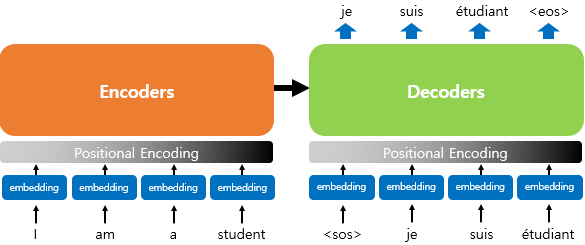

## 벡터화
- 자연어 문장(시퀀스)을 트랜스포머 입력으로 사용하기 위해 숫자(임베딩 벡터)로 변환   
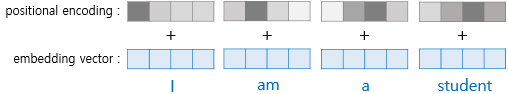  
> 트랜스포머 모델에서는 병렬적 처리때문에 위치정보를 추가하기 위해 Positional Encoding을 더함  


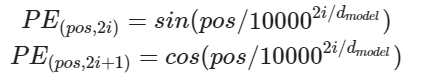

- "Attention is all you need"에 의하면 Positional encoding을 위해 여러 방법론들이 연구되어왔고, sinusodial기반의 Positional encoding을 채택하여 시퀀스 입/출력 길이의 가변성을 보장하였다고 한다.

> 개별 위치의 값이 주기함수에 기인(-1~1)하며, 개별 값들이 각각 다른 주기를 가지어 고유 위치 정보를 더해줄 수 있음.

### Positional Matrix 구현

In [63]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model) # (1, position, d_model), dtype=float32 
    
    # pos/10000^(2i/d_model) 를 반환
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, 
                            (2 * (i // 2)) / tf.cast(d_model, tf.float32)
                           )
        return position * angles # (position, d_model)
        
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            # tf.newaxis : 기존 텐서에 새 차원을 추가
            position = tf.range(position, dtype=tf.float32)[:, tf.newaxis], # (position, 1)
            i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # (1, d_model)
            d_model=d_model) 
        # angle_rads : (position, d_model)
        
        # 배열의 짝수 인덱스 : sin함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2]) # 짝수번쨰(0, 2, 4, ....) : (position, d_model/2)
        # 배열의 홀수 인덱스 : cos함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2]) # 홀수번쨰(1, 3, 5, ....) : (position, d_model/2)
        
        # sine, cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0) # 각 연산이 된 결과들을 쌓는다. : (2, position, d_model/2)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0]) # 순서를 바꾼다. : (position, d_model/2, 2)
        pos_encoding = tf.reshape(pos_encoding, [position, d_model]) # (position, d_model)
        
        pos_encoding = pos_encoding[tf.newaxis, ...] # (1, position, d_model)
        return tf.cast(pos_encoding, tf.float32) # type casting
    
    def call(self, inputs): # inputs을 (batch_size, seq_len, d_model) 이라고 하면(임베딩 후 결과)
        
        # [:, :tf.shape(inputs)[1], :] : slice (positional encoding) 
        # -> (batch_size, seq_len, d_model)
        
        # inputs에 의거, broadcasting이 일어남(self.pos_encoding이 inputs 배치에 합연산)
        
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

- 행의 크기가 50, 열의 크기가 512인 행렬을 그려봅시다. 이를테면, 최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양이 이와 같을 것입니다.

#### Q.위의 문장처럼 행의 크기가 50, 열의 크기가 512인 행렬을 만드는 코드를 완성하여 입력 벡터 모양을 시각화하세요.

(2, 50, 256)
(50, 256, 2)
(50, 512)


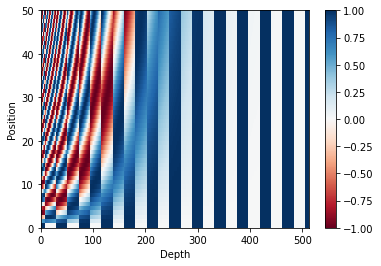

In [3]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### Q. 임베딩 벡터의 차원이 256이고 최대 문장의 길이가 30인 텍스트를 입력으로 하는 트랜스포머를 구현한다고 하였을 때, 적절한 포지셔널 인코딩 행렬의 크기를 추측해보고 위에 구현한 포지셔널 인코딩 레이어를 사용해 표현해 보세요.

(2, 30, 128)
(30, 128, 2)
(30, 256)


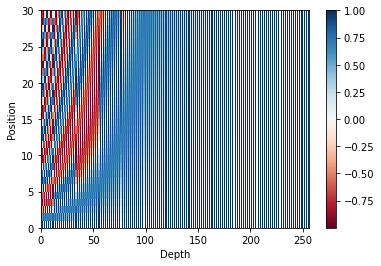

In [4]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Attention

## Attention
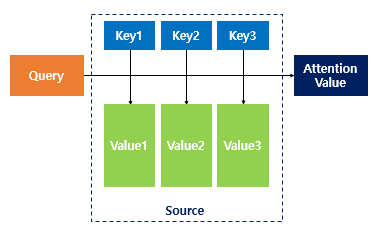

- Query에 대해서 모든 key들에 대한 유사도(내적)을 구함. : Q dot K
- 위에서 구한 값을 Value에 반영 : Q dot (K*V)
- 가중합을 해 줌 sigma(Q dot (K*V)) - Attention Score !

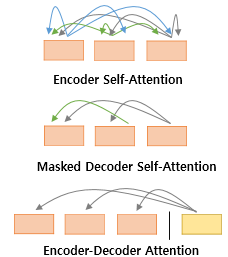

- 첫 번째 그림인 인코더 셀프 어텐션은 인코더에서 이루어지고,
- 두 번째 그림인 디코더 셀프 어텐션은 디코더에서 이루어지며,
- 세 번째 그림인 인코더-디코더 어텐션 또한 디코더에서 이루어집니다.

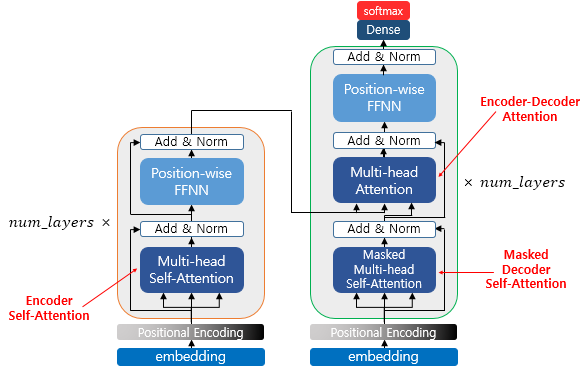

위 그림은 트랜스포머의 전체적인 아키텍처에서 각 어텐션이 위치한 곳을 나타냄

트랜스포머의 어텐션 함수 : 쿼리(Query), 키(Key), 밸류(Value) 는 기본적으로 '단어 (정보를 함축한) 벡터' 

'단어 벡터' 란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 단어 벡터.

그럼 위 세 가지 어텐션이 하는 일을 조금 더 자세히 알아보겠습니다.

    인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
    디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
    인코더-디코더 어텐션 : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

> 세 가지 어텐션 중 두 가지가 셀프 어텐션임.

### 셀프 어텐션(Self Attention)

셀프 어텐션이란 현재 문장 내의 단어들이 서로 유사도를 구하는 것. 
> 인코더-디코더 어텐션은 서로 다른 단어 목록(인코더 내 단어와 디코더 내 단어) 사이에서 유사도를 구함.

### Scaled Dot Product Attention

$$ Attention(Q,K,V)=softmax(\frac{QK^T}{√d_k})V$$ 

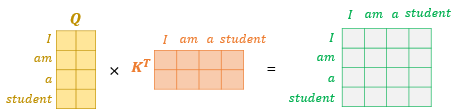

Query에 대해서 모든 key의 유사도를 구한다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/Untitled_16_neA52rZ.png)

- 계산후의 값이 Shape가 유지가 된다.

In [59]:
# Scaled Dot Product Attention
def scaled_dot_product_attention(query, key, value, mask): # (seq_len, depth)
    # Attention weight
    matmul_qk = tf.matmul(query, key, transpose_b=True) # (seq_len, seq_len)
    
    # Normalization
    depth = tf.cast(tf.shape(key)[-1], tf.float32) # depth = d_model / num_heads
    logits = matmul_qk / tf.math.sqrt(depth) # (seq_len, seq_len)
    
    # Add mask to Padding
    if mask is not None: 
        logits += (mask * -1e9)
        
    # softmax
    attention_weights = tf.nn.softmax(logits, axis=-1) # query에 대한 key의 softmax값 
    
    # Scaled Dot Product
    output = tf.matmul(attention_weights, value) # (seq_len, seq_len) x (seq_len, depth)
    return output # (seq_len, depth)

### 병렬로 어텐션 수행하기

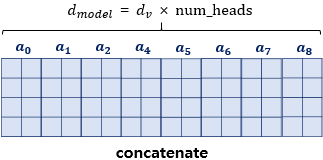

- d_model을 num_head로 나누어서 계산 후 concatenate

#### Multi-head Attention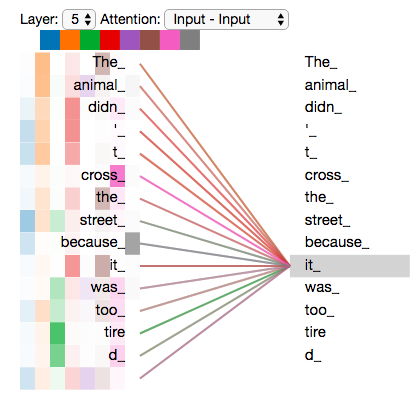

In [57]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        # to use scaled_dot_product_attention
        return tf.transpose(inputs, perm=[0, 2, 1, 3]) 
        
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # Q, K, V - Dense # (bs, seq_len, d_model)
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
         
        # Parallel Computing - Multi heads : (batch_size, num_heads, seq_len, depth)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # scaled_attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (batch_size, seq_len, num_heads, depth)
        
        # concatenate
        concat_attention = tf.reshape(scaled_attention,
                                     (batch_size, -1, self.d_model)) # (batch_size, seq_len, d_model)
        # Dense for final
        outputs = self.dense(concat_attention)
        
        return outputs
        

### Padding masking
![](https://d3s0tskafalll9.cloudfront.net/media/images/1365906-20200410103623697-871078599.max-800x600.png)

- 문장의 길이를 맞춰주기 위해서 사용하는 기법.
- 최대길이보다 짧을 때, 나머지 부분을 0을 채워서 처리

In [7]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32) # 0일 경우에 1(padding)로 표시
#     print(mask.shape)
    # (batch_size, 1, 1, seq_len)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [8]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


### Look-ahead masking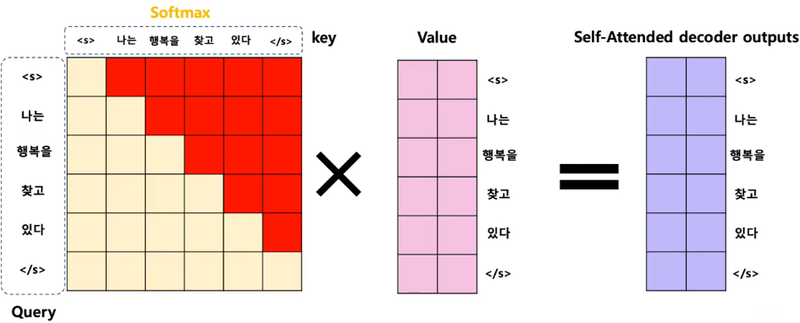

- 순환신경망과 달리, 입력이 한번에 들어가기 때문에 마스킹이 필요
    - 이전 단어들로부터 다음단어를 예측하는 작업을 진행(훈련)
    : 예측할 대상 이후에 있는 단어를 참고하지 못하도록 '마스킹'

In [9]:
def create_look_ahead_mask(x): # (batch_size, seq_len, d_model)
    seq_len = tf.shape(x)[1] 
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [10]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


숫자 0은 별도로 패딩을 진행해야 함.

In [11]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


- Padding mask : seq_len의 길이의 행렬이지만, 실제로는 값이 없는 곳을 나타내어 연산효율
- Look ahead mask : 디코더의 연산을 순차적으로 진행하기 위해서 미래 시점의 정보를 가림

# Encoder

![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_21_Y7Cy8sm.max-800x600.png)

In [12]:
# encoder layer implementation for a function

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # First layer : Multi Head Self Attention 
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })
    
    # Dropout, Layer Normalization(Residual connection)
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention) 
    # epsilon -  Small float added to variance to avoid dividing by zero. Defaults to 1e-3. 
    
    # Second layer : 2 Fully-connected Layer
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
        
    # Dropout, Layer Normalization(Residual connection)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs) 
    
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name
    )    

## Encoder Stacking (N layers)

- (Encoder + (Embedding layer + Positional encoding)) & Stacking
![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_22_teJgoCi.max-800x600.png)

- we will use less than 6 layers

In [13]:
def encoder(vocab_size,
           num_layers,
           units,
           d_model,
           num_heads,
           dropout,
           name="encoder"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # Embedding layer
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    # Scale Normalizing for positional encoding
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32)) 
    
    # Positional encoding
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # Encoder layer for num_layers
    for i in range(num_layers):
        outputs = encoder_layer(
                units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
        
    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name
        
    )
    

# Decoder
![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_23_vBHZ3i0.max-800x600.png)
![](https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_24_Kj9egLY.max-800x600.png)

- 디코더의 self attention, encoder-decoder attention또한 모두 Scale Dot Product attention을 수행

(2, 50, 256)
(50, 256, 2)
(50, 512)
Dummy Inputs Shape: (2, 50, 512)
Encoded Inputs Shape: (2, 50, 512)


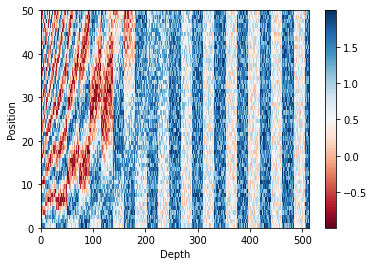

In [14]:
# 더미 데이터 생성
batch_size = 2
seq_len = 50
d_model = 512

dummy_inputs = tf.random.uniform((batch_size, seq_len, d_model))

# 포지셔널 인코딩 레이어 인스턴스 생성
pos_encoding_layer = PositionalEncoding(seq_len, d_model)

# 더미 데이터에 포지셔널 인코딩 적용
encoded_inputs = pos_encoding_layer(dummy_inputs)

print("Dummy Inputs Shape:", dummy_inputs.shape)
print("Encoded Inputs Shape:", encoded_inputs.shape)

# 시각화
plt.pcolormesh(encoded_inputs.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [15]:
tf.stack([[1,2,3],[5,6,8]], axis=0)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [5, 6, 8]], dtype=int32)>

## Encoder-Decoder Attention
- Query는 Decoder에서 나오지만, Key, Value는 Encoder에서 참고해야 함. (self-attention이 아님)
- 이를 통해, 입력 문장의 정보를 디코더에 전달

In [16]:
# Decoder layer implementation for a function

# 3 sublayers included

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    # encoder의 self attention
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask"
    )
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # Fisrt sub_layer : Masked Multihead Self Attention
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask        
        })
    
    # LayerNormalization
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)
    
    # Second sub_layer : Encoder-decoder Attention
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
        })
    
    # Dropout, Layer Normalization(Residual connection)
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)
    
    # Third layer : 2 Fully-connected Layer
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
        
    # Dropout, Layer Normalization(Residual connection)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2) 
    
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], 
        outputs=outputs, 
        name=name
    )    

In [61]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
            )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


# 챗봇을 위한 병렬 데이터 입력
- Cornell Movie-Dialogs Corpus 데이터셋(대화 문장 쌍) 사용
1. 50000개의 질문, 답변의 쌍을 추출
2. 단어와 구두점 사이에 공백 추가
3. ! ? , . 의 구두점을 제외한 특수문자를 제거

In [33]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

In [34]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [35]:
# 데이터 전처리(클리닝) 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower()
    sentence = sentence.strip() # 양쪽 공백을 제거

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다. 
    sentence = re.sub("[^a-zA-Z.?!,]", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [56]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    
        for i in range(len(conversation) - 1):
            # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

        if len(inputs) >= MAX_SAMPLES:
            return inputs, outputs
    return inputs, outputs

In [40]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 50000
전체 샘플 수 : 50000


In [41]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: she s not a . . .
전처리 후의 22번째 답변 샘플: lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


# 데이터 전처리


- TensorFlow Datasets SubwordTextEncoder 를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩 한다.
- 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
- 최대 길이 MAX_LENGTH 인 40을 넘는 문장들은 필터링한다.
- MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.


In [42]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [43]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
# 시작, 토큰에 부여된 정수를 출력
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8336]
END_TOKEN의 번호 : [8337]


In [44]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8338


위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, 
tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

In [45]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [62, 8, 36, 8177, 50]
정수 인코딩 후의 21번째 답변 샘플: [7835, 1126, 19, 59, 2, 4, 340, 10, 1683, 14, 1114, 749, 2607, 272, 17, 74, 14, 109, 2162, 864, 3, 63, 4, 23, 357, 208, 62, 8, 36, 901, 2310, 8112, 347, 1040, 5187, 4232, 335, 1]


In [46]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [47]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [48]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8338
필터링 후의 질문 샘플 개수: 43982
필터링 후의 답변 샘플 개수: 43982


# 교사 강요(Teacher Forcing)
tf.data.Dataset API 는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API입니다.

이를 적극 사용하기 위해서 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어주는 작업을 합니다.

이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 교사 강요(Teacher Forcing) 이라는 언어 모델의 훈련 기법을 이해해야만 합니다.

- 교사 강요를 사용하면, t+1에서 예측 시 t까지의 정보를 모델의 예측값을 이용하는 것이 아닌 실제 레이블을 입력

In [49]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # 학습 시 다음 데이터 배치를 준비하도록 처리

# 트랜스포머 모델 정의

In [50]:
def transformer(vocab_size,
               num_layers,
               units,
               d_model,
               num_heads,
               dropout,
               name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    enc_padding_mask = tf.keras.layers.Lambda( # 함수 기반으로 레이어 생성
        create_padding_mask, # (1, 1, seq_len)의 반환값
        output_shape = (1, 1, None),
        name='enc_padding_mask')(inputs)
    
    # for decoder masking 
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    # for Decoder padding
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, 
        output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)
    
    # Encoder
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])
    
    # Decoder
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # Fully connected layer
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
    

# 모델 생성

In [51]:
# 현재 세션에 존재하는 모든 텐서 객체들을 삭제 - 메모리 누수 방지 및 이전에 사용된 가중치 초기화
tf.keras.backend.clear_session() 

In [52]:
# 하이퍼파리마터
NUM_LAYERS = 2 # 인코더, 디코더 층의 개수
D_MODEL = 256 # 인코더, 디코더 내부 입,출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1

In [64]:
model = transformer(
    vocab_size=VOCAB_SIZE, 
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3188736     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

# Loss function

In [65]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, 
                                       MAX_LENGTH - 1)) # Time step ?

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, 
        reduction='none') # 각 샘플에 대한 손실값을 반환
    (y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32) # 패딩 토큰을 고려
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss) # 실제 고려된 손실

# Customized Learning rate
$$\text{learning_rate}=d^{−0.5}_{model}⋅min(\text{step_num}^{−0.5},\text{step_num⋅warmup_steps}^{−1.5}$$

In [66]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

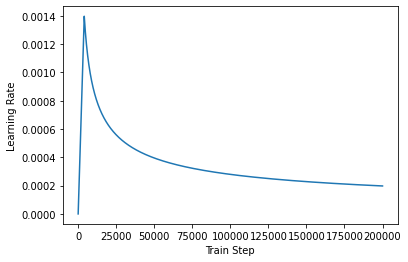

In [67]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Model Compile

In [68]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [69]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
688/688 [==============================] - 90s 105ms/step - loss: 2.1300 - accuracy: 0.0428
Epoch 2/10
688/688 [==============================] - 74s 107ms/step - loss: 1.5115 - accuracy: 0.0784
Epoch 3/10
688/688 [==============================] - 74s 107ms/step - loss: 1.4031 - accuracy: 0.0860
Epoch 4/10
688/688 [==============================] - 74s 107ms/step - loss: 1.3416 - accuracy: 0.0905
Epoch 5/10
688/688 [==============================] - 74s 107ms/step - loss: 1.2897 - accuracy: 0.0946
Epoch 6/10
688/688 [==============================] - 74s 107ms/step - loss: 1.2423 - accuracy: 0.0983
Epoch 7/10
688/688 [==============================] - 74s 107ms/step - loss: 1.1880 - accuracy: 0.1025
Epoch 8/10
688/688 [==============================] - 74s 107ms/step - loss: 1.1255 - accuracy: 0.1077
Epoch 9/10
688/688 [==============================] - 74s 107ms/step - loss: 1.0690 - accuracy: 0.1132
Epoch 10/10
688/688 [==============================] - 74s 107ms/step - l

# 챗봇 테스트하기
예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

    새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
    입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
    패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
    디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
    디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
    END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 decoder_inference() 함수를 만듭니다.

In [73]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [74]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [75]:
sentence_generation('Where have you been?')

입력 : Where have you been?
출력 : i m going to get a couple of hours .


'i m going to get a couple of hours .'

In [76]:
sentence_generation("It's a trap")

입력 : It's a trap
출력 : i m not afraid to hear it .


'i m not afraid to hear it .'